In [1]:
## This file replicates main results of the paper
## "Man Versus Machine Learning Revisited"
# by Yingguang (Conson) Zhang, Yandi Zhu, and Juhani T. Linnainmaa

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
from tqdm import tqdm
from functools import reduce
import statsmodels.api as sm
import scipy.stats as stats
from linearmodels import PanelOLS

from functions import utils
from functions import summary2

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rcParams.update({'font.size':13})
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = '--'
%config InlineBackend.figure_format = 'retina'

# Load Data

In [3]:
df_tmp = pd.read_parquet('../data/Results/df_train_new.parquet')

In [4]:
## w/ look-ahead bias ##
forecast_wLAB = pd.read_parquet('../data/Results/RF_with_lookahead_raw_005.parquet')
forecast_wLAB = forecast_wLAB.merge(df_tmp[['permno','YearMonth','prc_l1']], on=['permno','YearMonth'])

forecast_wLAB['BE_Q1'] = (forecast_wLAB['AF_q1'] - forecast_wLAB['RF_q1']) / forecast_wLAB['prc_l1']
forecast_wLAB['BE_Q2'] = (forecast_wLAB['AF_q2'] - forecast_wLAB['RF_q2']) / forecast_wLAB['prc_l1']
forecast_wLAB['BE_Q3'] = (forecast_wLAB['AF_q3'] - forecast_wLAB['RF_q3']) / forecast_wLAB['prc_l1']
forecast_wLAB['BE_A1'] = (forecast_wLAB['AF_y1'] - forecast_wLAB['RF_y1']) / forecast_wLAB['prc_l1']
forecast_wLAB['BE_A2'] = (forecast_wLAB['AF_y2'] - forecast_wLAB['RF_y2']) / forecast_wLAB['prc_l1']

nonNA = (~forecast_wLAB[['BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2']].isna()).sum(axis=1)
forecast_wLAB['BE_Avg'] = np.where(nonNA>1,forecast_wLAB[['BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2']].mean(axis=1,),np.nan)

In [5]:
## w/o look-ahead bias
forecast_woLAB = pd.read_parquet('../data/Results/RF_wo_lookahead_raw_005.parquet')
forecast_woLAB = forecast_woLAB.merge(df_tmp[['permno','YearMonth','prc_l1']], on=['permno','YearMonth'])

forecast_woLAB['BE_Q1'] = (forecast_woLAB['AF_q1'] - forecast_woLAB['RF_q1']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_Q2'] = (forecast_woLAB['AF_q2'] - forecast_woLAB['RF_q2']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_Q3'] = (forecast_woLAB['AF_q3'] - forecast_woLAB['RF_q3']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_A1'] = (forecast_woLAB['AF_y1'] - forecast_woLAB['RF_y1']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_A2'] = (forecast_woLAB['AF_y2'] - forecast_woLAB['RF_y2']) / forecast_woLAB['prc_l1']

nonNA = (~forecast_woLAB[['BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2']].isna()).sum(axis=1)
forecast_woLAB['BE_Avg'] = np.where(nonNA>1,forecast_woLAB[['BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2']].mean(axis=1,),np.nan)

# Table 3

In [6]:
## Panel B of Table 3 ##
## w/ look-ahead bias ##
summary_table = []
for i in [1,2,3]:
    forecast_all = forecast_wLAB.dropna(subset=[f'RF_q{i}',f'AE_q{i}',f'AF_q{i}']).copy()
    forecast_all['RF-AE'] = forecast_all[f'RF_q{i}'] - forecast_all[f'AE_q{i}']
    forecast_all['AF-AE'] = forecast_all[f'AF_q{i}'] - forecast_all[f'AE_q{i}']
    forecast_all['(RF-AE)2'] = (forecast_all[f'RF_q{i}'] - forecast_all[f'AE_q{i}'])**2
    forecast_all['(AF-AE)2'] = (forecast_all[f'AF_q{i}'] - forecast_all[f'AE_q{i}'])**2
    
    mean_t = forecast_all.groupby('YearMonth')[[f'RF_q{i}',f'AF_q{i}',f'AE_q{i}','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']].mean()
    mean = mean_t.mean().round(3)
    mean.index = ['RF','AF','AE','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']
    mean['t(RF-AE)'] = sm.OLS(mean_t['RF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':3}).tvalues['const']
    mean['t(AF-AE)'] = sm.OLS(mean_t['AF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':3}).tvalues['const']
    mean['Obs'] = forecast_all.shape[0]
    mean = mean.round(3)
    mean.name = f'Q{i}'
    summary_table.append(mean)
    
for i in [1,2]:
    forecast_all = forecast_wLAB.dropna(subset=[f'RF_y{i}',f'AE_y{i}',f'AF_y{i}']).copy()
    forecast_all['RF-AE'] = forecast_all[f'RF_y{i}'] - forecast_all[f'AE_y{i}']
    forecast_all['AF-AE'] = forecast_all[f'AF_y{i}'] - forecast_all[f'AE_y{i}']
    forecast_all['(RF-AE)2'] = (forecast_all[f'RF_y{i}'] - forecast_all[f'AE_y{i}'])**2
    forecast_all['(AF-AE)2'] = (forecast_all[f'AF_y{i}'] - forecast_all[f'AE_y{i}'])**2
    
    mean_t = forecast_all.groupby('YearMonth')[[f'RF_y{i}',f'AF_y{i}',f'AE_y{i}','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']].mean()
    mean = mean_t.mean().round(3)
    mean.index = ['RF','AF','AE','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']
    mean['t(RF-AE)'] = sm.OLS(mean_t['RF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':12}).tvalues['const']
    mean['t(AF-AE)'] = sm.OLS(mean_t['AF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':12}).tvalues['const']
    mean['Obs'] = forecast_all.shape[0]
    mean = mean.round(3)
    mean.name = f'Y{i}'
    summary_table.append(mean)

rlt = pd.concat(summary_table, axis=1).T[['RF','AF','AE','RF-AE','t(RF-AE)','AF-AE','t(AF-AE)','(RF-AE)2','(AF-AE)2','Obs']]
rlt.to_clipboard()
rlt

,RF,AF,AE,RF-AE,t(RF-AE),AF-AE,t(AF-AE),(RF-AE)2,(AF-AE)2,Obs
Q1,0.294,0.319,0.294,-0.000,-0.143,0.026,6.502,0.065,0.070,1010411.0
Q2,0.324,0.376,0.327,-0.003,-0.645,0.049,10.277,0.082,0.090,1106291.0
Q3,0.344,0.412,0.344,-0.001,-0.128,0.068,11.438,0.105,0.120,1016839.0
Y1,1.198,1.314,1.169,0.029,2.016,0.146,6.173,0.593,0.642,1246126.0
Y2,1.362,1.731,1.367,-0.005,-0.095,0.364,8.282,1.628,1.837,1126934.0


In [7]:
### Panel C of Table 3 ###
## w/o look-ahead bias
summary_table = []
for i in [1,2,3]:
    forecast_all = forecast_woLAB.dropna(subset=[f'RF_q{i}',f'AE_q{i}',f'AF_q{i}']).copy()
    forecast_all['RF-AE'] = forecast_all[f'RF_q{i}'] - forecast_all[f'AE_q{i}']
    forecast_all['AF-AE'] = forecast_all[f'AF_q{i}'] - forecast_all[f'AE_q{i}']
    forecast_all['(RF-AE)2'] = (forecast_all[f'RF_q{i}'] - forecast_all[f'AE_q{i}'])**2
    forecast_all['(AF-AE)2'] = (forecast_all[f'AF_q{i}'] - forecast_all[f'AE_q{i}'])**2
    
    mean_t = forecast_all.groupby('YearMonth')[[f'RF_q{i}',f'AF_q{i}',f'AE_q{i}','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']].mean()
    mean = mean_t.mean().round(3)
    mean.index = ['RF','AF','AE','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']
    mean['t(RF-AE)'] = sm.OLS(mean_t['RF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':3}).tvalues['const']
    mean['t(AF-AE)'] = sm.OLS(mean_t['AF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':3}).tvalues['const']
    mean['Obs'] = forecast_all.shape[0]
    mean = mean.round(3)
    mean.name = f'Q{i}'
    summary_table.append(mean)
    # break
    
for i in [1,2]:
    forecast_all = forecast_woLAB.dropna(subset=[f'RF_y{i}',f'AE_y{i}',f'AF_y{i}']).copy()
    forecast_all['RF-AE'] = forecast_all[f'RF_y{i}'] - forecast_all[f'AE_y{i}']
    forecast_all['AF-AE'] = forecast_all[f'AF_y{i}'] - forecast_all[f'AE_y{i}']
    forecast_all['(RF-AE)2'] = (forecast_all[f'RF_y{i}'] - forecast_all[f'AE_y{i}'])**2
    forecast_all['(AF-AE)2'] = (forecast_all[f'AF_y{i}'] - forecast_all[f'AE_y{i}'])**2
    
    mean_t = forecast_all.groupby('YearMonth')[[f'RF_y{i}',f'AF_y{i}',f'AE_y{i}','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']].mean()
    mean = mean_t.mean().round(3)
    mean.index = ['RF','AF','AE','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']
    mean['t(RF-AE)'] = sm.OLS(mean_t['RF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':12}).tvalues['const']
    mean['t(AF-AE)'] = sm.OLS(mean_t['AF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':12}).tvalues['const']
    mean['Obs'] = forecast_all.shape[0]
    mean = mean.round(3)
    mean.name = f'Y{i}'
    summary_table.append(mean)

rlt = pd.concat(summary_table, axis=1).T[['RF','AF','AE','RF-AE','t(RF-AE)','AF-AE','t(AF-AE)','(RF-AE)2','(AF-AE)2','Obs']]
rlt.to_clipboard()
rlt

,RF,AF,AE,RF-AE,t(RF-AE),AF-AE,t(AF-AE),(RF-AE)2,(AF-AE)2,Obs
Q1,0.294,0.319,0.294,-0.000,-0.143,0.026,6.502,0.065,0.070,1010411.0
Q2,0.323,0.376,0.327,-0.003,-0.769,0.049,10.277,0.085,0.090,1106291.0
Q3,0.343,0.412,0.344,-0.002,-0.277,0.068,11.438,0.114,0.120,1016839.0
Y1,1.198,1.314,1.169,0.029,2.016,0.146,6.173,0.593,0.642,1246126.0
Y2,1.368,1.731,1.367,0.001,0.019,0.364,8.282,1.788,1.837,1126934.0


In [8]:
## Panel C of Table 3: Accuracy Compare
mse = []
for h in ['q1','q2','q3','y1','y2']:
    mse.append(((forecast_wLAB[f'RF_{h}'] - forecast_wLAB[f'AE_{h}'])**2).groupby(forecast_wLAB['YearMonth']).mean())
mse_wLAB = pd.concat(mse, axis=1)

mse = []
for h in ['q1','q2','q3','y1','y2']:
    mse.append(((forecast_woLAB[f'RF_{h}'] - forecast_woLAB[f'AE_{h}'])**2).groupby(forecast_woLAB['YearMonth']).mean())
mse_woLAB = pd.concat(mse, axis=1)

# Hughes et al. (2008)
forecast_Hughes = pd.read_parquet('../data/Results/Hughes_eps.parquet')
mse = []
for h in ['q1','q2','q3','y1','y2']:
    mse.append(((forecast_Hughes[f'LF_{h}'] - forecast_Hughes[f'AE_{h}'])**2).groupby(forecast_Hughes['YearMonth']).mean())
mse_Hughes = pd.concat(mse, axis=1)

In [9]:
## Compare MSE between w/ and w/o look-ahead bias
mdl = []
for i in range(5):
    mdl.append(sm.OLS(endog=mse_wLAB[i]-mse_woLAB[i], 
                      exog=[1]*len(mse_woLAB)).fit(cov_type = 'HAC', 
                                                 cov_kwds = {'maxlags':12}))
summary2.summary_col(mdl, float_format='%.3f')

,y,1,2,3,4
const,-0.000,-0.003,-0.009,-0.000,-0.160
,(-0.85),(-6.52),(-6.64),(-0.53),(-10.80)


In [10]:
## Compare MSE between w/o look-ahead bias and Hughes et al. (2008)
mdl = []
for i in range(5):
    mdl.append(sm.OLS(endog=mse_Hughes[i]-mse_woLAB[i], 
                      exog=[1]*len(mse_woLAB)).fit(cov_type = 'HAC', 
                                                 cov_kwds = {'maxlags':12}))
summary2.summary_col(mdl, float_format='%.3f')

,y,1,2,3,4
const,0.002,0.003,0.005,-0.004,0.001
,(1.11),(1.10),(1.17),(-0.55),(0.02)


# Table 4

In [11]:
forecast_wLAB = forecast_wLAB[['permno','YearMonth',
                               'BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2',
                               'RF_q1','RF_q2','RF_q3','RF_y1','RF_y2',
                               'BE_Avg',
                              ]].copy()
forecast_wLAB.set_index(['permno','YearMonth'], inplace=True)
forecast_wLAB.columns = [ f'{c}_wLAB' for c in forecast_wLAB.columns]

In [12]:
forecast_woLAB = forecast_woLAB[['permno','YearMonth',
                               'BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2',
                               'RF_q1','RF_q2','RF_q3','RF_y1','RF_y2',
                               'BE_Avg',
                              ]].copy()
forecast_woLAB.set_index(['permno','YearMonth'], inplace=True)
forecast_woLAB.columns = [ f'{c}_woLAB' for c in forecast_woLAB.columns]

In [13]:
Bias_all = forecast_wLAB.merge(forecast_woLAB, on=['permno','YearMonth'])
# Test df
df = df_tmp.merge(Bias_all, on=['permno','YearMonth'])

In [14]:
all_factor = pd.read_csv('../data/Other/ff5_factors_m.CSV')
all_factor['YearMonth'] = pd.to_datetime(all_factor['yyyymm'], format='%Y%m') + MonthEnd(0)
# We do sort at the end of month t and use the return of month t+1
# So we need to shift the factor return by 1 month
all_factor['YearMonth'] = all_factor['YearMonth'] + MonthEnd(-1)

factor_dict = {'Ret':['ones'],
              }
factor_dict2 = {'CAPM':['ones','Mkt_RF'],
               'FF3':['ones','Mkt_RF','SMB','HML'],
               'FF5':['ones','Mkt_RF','SMB', 'HML', 'RMW', 'CMA'],
              }

In [15]:
# Table 4: Replication with look-ahead bias
sort_var = 'BE_Avg_wLAB'
num_level = 5
_,vwret2 = utils.SingleSort(df, 
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ME', quantile_filter=None)
result2 = utils.SingleSort_RetAna(_,vwret2,'YearMonth',factor_data=all_factor,factor_dict=factor_dict,lag=None)
result2.to_clipboard()
result2

Var:BE_Avg_wLAB, Delete 90119 rows due to missing values, raw data 1350764 rows --> new data 1260645 rows


,1,2,3,4,5,H-L
Ret,1.37,0.93,0.60,0.24,-0.17,-1.55
,(6.67),(4.32),(2.40),(0.76),(-0.42),(-4.95)


In [16]:
# Table 4: Replication without look-ahead bias
sort_var = 'BE_Avg_woLAB'
num_level = 5
_,vwret3 = utils.SingleSort(df, 
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ME', quantile_filter=None)
result3 = utils.SingleSort_RetAna(_,vwret3,'YearMonth',factor_data=all_factor,factor_dict=factor_dict,lag=None)
result3.to_clipboard()
result3

Var:BE_Avg_woLAB, Delete 90119 rows due to missing values, raw data 1350764 rows --> new data 1260645 rows


,1,2,3,4,5,H-L
Ret,1.01,0.89,0.93,0.80,0.74,-0.27
,(4.87),(4.10),(3.68),(2.62),(1.80),(-0.86)


# Table 1 & 5

In [17]:
def merge_by_col(df1,df2):
    '''
    Merge two dataframes: (coefs) and (standard-errors) side-by-side
    '''
    new_columns = []
    
    for col_name in df1.columns:
        new_columns.append(df1[col_name])
        new_columns.append(df2[col_name])

    df_merged = pd.concat(new_columns, axis=1)

    new_col_names = []
    for i, col_name in enumerate(df1.columns):
        new_col_names.append(col_name)
        new_col_names.append('')

    df_merged.columns = new_col_names

    return df_merged

def Factor_Exposure(vwret, num_level, time_id, factor_data, factor_dict, lag, regressor_order=['ones']):
    '''
    This function is used to get common risk factor exposure
    vwret is output from SingleSort
    e.g.: 
        Factor_Exposure(vwret1, num_level, 'YearMonth', 
                        all_factor, factor_dict2, 12, 
                        regressor_order = ['ones','Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'])
    '''
    vwret = vwret.merge(factor_data, left_index=True, right_on=time_id)
    vwret['ones'] = 1
    coefs = []
    coefs_t = []
    
    # For each test factor model
    for name, factor_list in factor_dict.items():
        
        model_i = sm.OLS(endog=vwret['H-L'], 
                         exog=vwret[factor_list], 
                         missing='drop')
        if lag:
            model_i = model_i.fit(cov_type = 'HAC', cov_kwds = {'maxlags':lag})
        else:
            model_i = model_i.fit(cov_type = 'HC0')
        
        coefs.append(summary2.summary_params(model_i)['Coef.'].rename(name))
        coefs_t.append(summary2.summary_params(model_i)['t'].rename(name))
        # model.append(model_i)
            
    coefs = pd.concat(coefs,axis=1)
    coefs_t = pd.concat(coefs_t,axis=1)
    result = merge_by_col(coefs, coefs_t)
    return result

In [18]:
# Panel B of Table 5
exposure2 = Factor_Exposure(vwret2, num_level, 'YearMonth', 
                all_factor, factor_dict2, None, regressor_order = ['ones','Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'])
exposure2.to_clipboard()
exposure2.round(2)

,CAPM,,FF3,,FF5,
ones,-1.97,-7.15,-2.06,-8.51,-1.67,-5.95
Mkt_RF,0.61,7.65,0.57,7.68,0.43,5.81
SMB,NaN,NaN,0.89,7.32,0.66,5.17
HML,NaN,NaN,0.61,5.21,0.89,6.16
RMW,NaN,NaN,NaN,NaN,-0.75,-4.09
CMA,NaN,NaN,NaN,NaN,-0.30,-1.11


In [19]:
# Panel C of Table 5
exposure3 = Factor_Exposure(vwret3, num_level, 'YearMonth', 
                all_factor, factor_dict2, None, regressor_order = ['ones','Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'])
exposure3.to_clipboard()
exposure3.round(2)

,CAPM,,FF3,,FF5,
ones,-0.68,-2.52,-0.77,-3.32,-0.44,-1.63
Mkt_RF,0.60,7.78,0.54,7.74,0.43,5.86
SMB,NaN,NaN,0.97,8.02,0.76,5.85
HML,NaN,NaN,0.59,5.34,0.80,5.60
RMW,NaN,NaN,NaN,NaN,-0.70,-3.76
CMA,NaN,NaN,NaN,NaN,-0.15,-0.56


In [20]:
# Panel D of Table 5
sort_var = 'BE_Avg_woLAB'
num_level = 5
factor_dict = {'FFC6':['ones','Mkt_RF','SMB', 'HML', 'RMW', 'CMA','MOM'],
               'q4':['ones','R_MKT','R_ME','R_IA','R_ROE'],
               'q-factor':['ones','R_MKT','R_ME','R_IA','R_ROE','R_EG'],
               'SY':['ones','Mkt_RF','SMB_SY','MGMT', 'PERF'],
               'DHS':['ones','Mkt_RF','PEAD', 'FIN'],
              }
_,vwret3 = utils.SingleSort(df, 
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ME', quantile_filter=None)
result3 = utils.SingleSort_RetAna(_,vwret3,'YearMonth',factor_data=all_factor,factor_dict=factor_dict,lag=None)
result3.to_clipboard()
result3

Var:BE_Avg_woLAB, Delete 90119 rows due to missing values, raw data 1350764 rows --> new data 1260645 rows


,1,2,3,4,5,H-L
FFC6,0.31,0.18,0.30,0.23,0.26,-0.05
,(6.89),(3.58),(3.51),(2.08),(1.42),(-0.26)
q4,0.30,0.18,0.26,0.18,0.21,-0.09
,(5.74),(3.23),(2.19),(1.11),(0.82),(-0.32)
q-factor,0.27,0.16,0.29,0.24,0.27,-0.01
,(5.26),(2.76),(2.32),(1.55),(0.98),(-0.02)
SY,0.29,0.20,0.37,0.34,0.35,0.05
,(5.97),(3.57),(3.18),(2.39),(1.35),(0.20)
DHS,0.28,0.15,0.31,0.32,0.56,0.29
,(4.76),(2.70),(2.59),(1.73),(1.76),(0.80)


# Table 6

In [22]:
## With look-ahead bias
vwret = vwret2
pre_2000 = vwret[vwret.index<='1999-12-31']
post_2000 = vwret[vwret.index>'1999-12-31']

mdl1 = sm.OLS(endog=vwret['H-L'], exog=[1]*len(vwret)).fit(cov_type = 'HC0')
mdl2 = sm.OLS(endog=pre_2000['H-L'], exog=[1]*len(pre_2000)).fit(cov_type = 'HC0')
mdl3 = sm.OLS(endog=post_2000['H-L'], exog=[1]*len(post_2000)).fit(cov_type = 'HC0')
rlt = summary2.summary_col([mdl1, mdl2, mdl3], float_format='%.2f')
rlt['Pre-Post'] = [np.round(pre_2000['H-L'].mean() - post_2000['H-L'].mean(),2),
                   np.round(stats.ttest_ind(pre_2000['H-L'], post_2000['H-L']).pvalue,2)
                  ]
rlt.to_clipboard()
rlt

,H-L I,H-L II,H-L III,Pre-Post
const,-1.55,-1.76,-1.40,-0.36
,(-4.95),(-4.50),(-3.07),0.57


In [23]:
## Without look-ahead bias
vwret = vwret3
pre_2000 = vwret[vwret.index<='1999-12-31']
post_2000 = vwret[vwret.index>'1999-12-31']

mdl1 = sm.OLS(endog=vwret['H-L'], exog=[1]*len(vwret)).fit(cov_type = 'HC0')
mdl2 = sm.OLS(endog=pre_2000['H-L'], exog=[1]*len(pre_2000)).fit(cov_type = 'HC0')
mdl3 = sm.OLS(endog=post_2000['H-L'], exog=[1]*len(post_2000)).fit(cov_type = 'HC0')
rlt = summary2.summary_col([mdl1, mdl2, mdl3], float_format='%.2f')
rlt['Pre-Post'] = [np.round(pre_2000['H-L'].mean() - post_2000['H-L'].mean(),2),
                   np.round(stats.ttest_ind(pre_2000['H-L'], post_2000['H-L']).pvalue,2)
                  ]
rlt.to_clipboard()
rlt

,H-L I,H-L II,H-L III,Pre-Post
const,-0.27,-0.50,-0.10,-0.40
,(-0.86),(-1.32),(-0.23),0.53


# Figure 2

In [24]:
#######################################################################
## To replicate this figure, we need earnings forecast data from BHL ##
####################################################################### 
## BHL
forecast_ORIG = pd.read_csv('../data/BHL/Conditional_Bias.csv')
forecast_ORIG['DATE'] = pd.to_datetime(forecast_ORIG['DATE'],format='%Y-%m') + MonthEnd(0)
forecast_ORIG.rename(columns={'PERMNO':'permno','DATE':'YearMonth'}, inplace=True)
df = df.merge(forecast_ORIG, on=['permno','YearMonth'], how='left')
sort_var = 'Avg_bias'
num_level = 5
_,vwret1 = utils.SingleSort(df,
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ME', quantile_filter=None)

Var:Avg_bias, Delete 128135 rows due to missing values, raw data 1350764 rows --> new data 1222629 rows


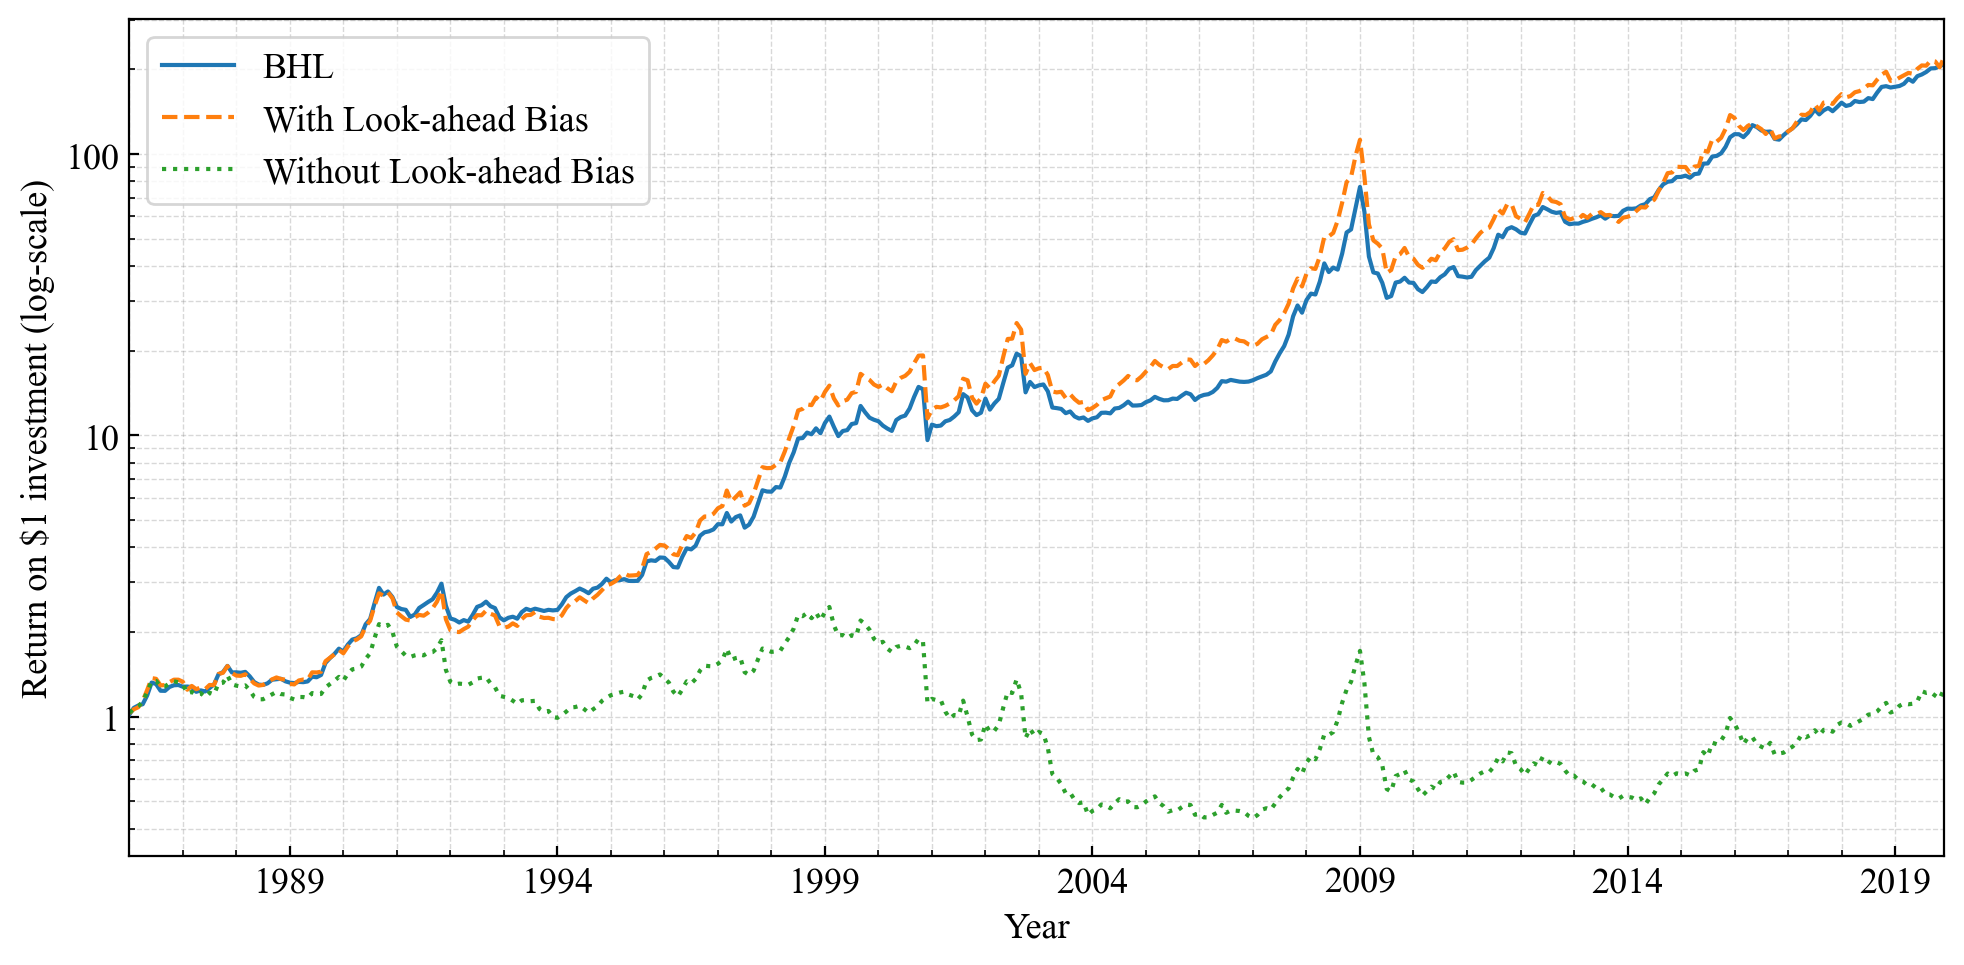

In [25]:
## Figure 9
(1-vwret1['H-L']/100).cumprod().plot(figsize=(10,5), label='BHL')
(1-vwret2['H-L']/100).cumprod().plot(figsize=(10,5), label='With Look-ahead Bias', linestyle='--')
(1-vwret3['H-L']/100).cumprod().plot(figsize=(10,5), label='Without Look-ahead Bias', linestyle=':',)
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)
plt.legend()
plt.yticks([1,10,100],[1,10,100])
plt.xlabel('Year')
plt.ylabel('Return on $1 investment (log-scale)')
plt.tight_layout()
plt.savefig('../data/Results/cumret.png',dpi=500)

# Table C.1

In [26]:
## Long-short Portfolio perform for each horizon (without look-ahead bias)
num_level = 5
factor_dict = {'Ret':['ones'],
               'CAPM':['ones','Mkt_RF'],
               'FF3':['ones','Mkt_RF','SMB', 'HML'],
               'FF5':['ones','Mkt_RF','SMB', 'HML', 'RMW', 'CMA'],
               'FFC6':['ones','Mkt_RF','SMB', 'HML', 'RMW', 'CMA','MOM'],
               'HXZ':['ones','R_MKT','R_ME','R_IA','R_ROE'],
               'HMXZ':['ones','R_MKT','R_ME','R_IA','R_ROE','R_EG'],
               'SY':['ones','Mkt_RF','SMB_SY','MGMT', 'PERF'],
               'DHS':['ones','Mkt_RF','PEAD', 'FIN'],
              }

rlts = []
for sort_var in ['BE_Q1_woLAB','BE_Q2_woLAB','BE_Q3_woLAB','BE_A1_woLAB','BE_A2_woLAB']:
    _,vwret = utils.SingleSort(df, 
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ME', quantile_filter=None)
    result = utils.SingleSort_RetAna(_,vwret,'YearMonth',factor_data=all_factor,factor_dict=factor_dict,lag=None)
    rlts.append(result['H-L'])
    # break
rlts = pd.concat(rlts, axis=1)
rlts.columns = ['Q1','Q2','Q3','A1','A2']
rlts.to_clipboard()
rlts

Var:BE_Q1_woLAB, Delete 340743 rows due to missing values, raw data 1350764 rows --> new data 1010021 rows
Var:BE_Q2_woLAB, Delete 244939 rows due to missing values, raw data 1350764 rows --> new data 1105825 rows
Var:BE_Q3_woLAB, Delete 334380 rows due to missing values, raw data 1350764 rows --> new data 1016384 rows
Var:BE_A1_woLAB, Delete 105194 rows due to missing values, raw data 1350764 rows --> new data 1245570 rows
Var:BE_A2_woLAB, Delete 224369 rows due to missing values, raw data 1350764 rows --> new data 1126395 rows


,Q1,Q2,Q3,A1,A2
Ret,-0.41,-0.36,-0.22,-0.18,0.06
,(-1.43),(-1.18),(-0.74),(-0.61),(0.20)
CAPM,-0.78,-0.75,-0.62,-0.54,-0.32
,(-3.04),(-2.77),(-2.32),(-2.11),(-1.25)
FF3,-0.82,-0.86,-0.72,-0.60,-0.40
,(-3.53),(-3.61),(-3.00),(-2.64),(-1.82)
FF5,-0.34,-0.47,-0.31,-0.19,-0.09
,(-1.39),(-1.75),(-1.18),(-0.74),(-0.36)
FFC6,-0.03,-0.06,0.09,0.18,0.29
,(-0.16),(-0.35),(0.50),(0.90),(1.60)


# Table C.2

In [27]:
## Equal-weighted Portfolios ##
df['ones'] = 1
## With look-ahead bias
sort_var = 'BE_Avg_wLAB'
num_level = 5
factor_dict = {'Ret':['ones'],
               'FF5':['ones','Mkt_RF','SMB', 'HML', 'RMW', 'CMA'],
              }

_,vwret = utils.SingleSort(df, 
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ones', quantile_filter=None)
result = utils.SingleSort_RetAna(_,vwret,'YearMonth',factor_data=all_factor,factor_dict=factor_dict,lag=None)
result.to_clipboard()
result

Var:BE_Avg_wLAB, Delete 90119 rows due to missing values, raw data 1350764 rows --> new data 1260645 rows


,1,2,3,4,5,H-L
Ret,1.80,1.30,0.94,0.58,0.44,-1.36
,(7.24),(5.39),(3.42),(1.82),(1.06),(-5.02)
FF5,1.13,0.56,0.18,-0.19,-0.26,-1.39
,(16.12),(11.96),(2.93),(-1.68),(-0.97),(-4.76)


In [28]:
## Without look-ahead bias
sort_var = 'BE_Avg_woLAB'
num_level = 5
_,vwret = utils.SingleSort(df,  
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ones', quantile_filter=None)
result = utils.SingleSort_RetAna(_,vwret,'YearMonth',factor_data=all_factor,factor_dict=factor_dict,lag=None)
result.to_clipboard()
result

Var:BE_Avg_woLAB, Delete 90119 rows due to missing values, raw data 1350764 rows --> new data 1260645 rows


,1,2,3,4,5,H-L
Ret,1.13,1.02,0.97,0.86,1.08,-0.05
,(4.55),(4.15),(3.52),(2.70),(2.61),(-0.18)
FF5,0.48,0.27,0.21,0.09,0.38,-0.10
,(7.01),(6.05),(2.99),(0.77),(1.38),(-0.34)


# Table C.3

In [29]:
## Fama-macbeth Regression
# Panel A of Table C.3: Replication with look-ahead bias
results = []
for idx in ['Q1','Q2','Q3','A1','A2','Avg']:
    df_tmp = df[['YearMonth','bh1m',f'BE_{idx}_wLAB',f'BE_{idx}_woLAB']].dropna().copy()
    df_tmp[[f'BE_{idx}_wLAB',f'BE_{idx}_woLAB']] = df_tmp.groupby('YearMonth',group_keys=False)[[f'BE_{idx}_wLAB',f'BE_{idx}_woLAB']]\
                         .transform(lambda x: x.clip(x.quantile(0.01),x.quantile(0.99)))
    rlt = utils.fama_macbeth(df_tmp,
                   formula_list = [f'bh1m~BE_{idx}_wLAB'],
                   time_id='YearMonth', lags=12, stars=False)
    rlt = rlt.rename(index={f'BE_{idx}_wLAB':'Bias'})
    results.append(rlt)

results = pd.concat(results,axis=1)
results.to_clipboard()
results

,1,1,1,1,1,1
Intercept,0.0100,0.0116,0.0128,0.0095,0.0122,0.0108
,(3.96),(4.75),(5.28),(3.98),(5.26),(4.53)
Bias,-0.2184,-0.5114,-0.6190,0.0102,-0.0857,-0.1717
,(-1.83),(-5.07),(-6.72),(0.27),(-4.40),(-3.22)
N,1010021,1105825,1016384,1245570,1126395,1260645
R2,1.1051,1.0856,1.1556,1.1850,1.1843,1.1896


In [30]:
# Panel B of Table C.3: Replication with look-ahead bias
results = []
for idx in ['Q1','Q2','Q3','A1','A2','Avg']:
    df_tmp = df[['YearMonth','bh1m',f'BE_{idx}_wLAB',f'BE_{idx}_woLAB']].dropna().copy()
    df_tmp[[f'BE_{idx}_wLAB',f'BE_{idx}_woLAB']] = df_tmp.groupby('YearMonth',group_keys=False)[[f'BE_{idx}_wLAB',f'BE_{idx}_woLAB']]\
                         .transform(lambda x: x.clip(x.quantile(0.01),x.quantile(0.99)))
    rlt = utils.fama_macbeth(df_tmp,
                   formula_list = [f'bh1m~BE_{idx}_woLAB'],
                   time_id='YearMonth', lags=12, stars=False)
    rlt = rlt.rename(index={f'BE_{idx}_woLAB':'Bias'})
    results.append(rlt)
results = pd.concat(results,axis=1)
results.to_clipboard()
results

,1,1,1,1,1,1
Intercept,0.0100,0.0100,0.0099,0.0095,0.0095,0.0092
,(3.96),(4.13),(4.20),(3.98),(4.17),(3.88)
Bias,-0.2184,-0.0803,-0.0545,0.0102,0.0146,-0.0023
,(-1.83),(-0.72),(-0.53),(0.27),(0.74),(-0.04)
N,1010021,1105825,1016384,1245570,1126395,1260645
R2,1.1051,1.0525,1.0691,1.1850,1.1313,1.1436


# Table D.1

In [31]:
def _col_params(model):
    res = pd.DataFrame()
    res_se = pd.DataFrame()
    other_info = {}
    def find_stars(p):
        if p <= 0.01:
            return '***'
        elif (p > 0.01) & (p <= 0.05):
            return '**'
        elif (p > 0.05) & (p <= 0.10):
            return '*'
        elif p > 0.1:
            return ''
        
    res['coef.'] = model.params.round(3) # + model.pvalues.map(find_stars) #+ find_stars(model.pvalues)
    res_se['t-stats'] = model.tstats.round(2)
    
    other_info['N'] = model.nobs
    other_info['R2'] = model.rsquared
    return res,res_se,other_info

In [32]:
def summary_col(results, regressor_order = None):
    res_all, res_se_all, other_info_all = [], [], []
    
    for x in results:
        res,res_se,other_info = _col_params(x)
        res_all.append(res)
        res_se_all.append(res_se)
        other_info_all.append(other_info)
        
    # cols = [_col_params(x) for x in results]
    col_names = [str(i) for i in range(1,len(res_all)+1)]
    
    res_all = pd.concat(res_all, axis=1)
    res_se_all = pd.concat(res_se_all, axis=1)
    other_info_all = pd.DataFrame(other_info_all).T
    
    res_all.columns = col_names
    res_se_all.columns = col_names
    other_info_all.columns = col_names
    
    if regressor_order:
        res_all = res_all.loc[regressor_order,:]
        res_se_all = res_se_all.loc[regressor_order,:]
    else:
        regressor_order = res_all.index
    
    result = pd.concat([res_all.reset_index(drop=True), 
                        res_se_all.reset_index(drop=True)]).sort_index(kind='merge')
    
    result.index = [item for elem in regressor_order for item in (elem, "")]
    
    result = pd.concat([result, other_info_all])
    return result

In [33]:
######################################################################
## To replicate this Table, we need earnings forecast data from BHL ##
######################################################################
## Reciver BHL's earnings forecast from bias
df['Forecast_q1'] = df['EPS_ana_q1'] - df['Q1_bias']*df['prc_l1']
df['Forecast_q2'] = df['EPS_ana_q2'] - df['Q2_bias']*df['prc_l1']
df['Forecast_q3'] = df['EPS_ana_q3'] - df['Q3_bias']*df['prc_l1']

df['Forecast_y1'] = df['EPS_ana_y1'] - df['A1_bias']*df['prc_l1']
df['Forecast_y2'] = df['EPS_ana_y2'] - df['A2_bias']*df['prc_l1']

## Q1
df_ = df.dropna(subset = ['EPS_true_q1','Forecast_q1','Forecast_q2',
                          'EPS_true_l1_q1','EPS_ana_q1','EPS_ana_q2',
                          'RF_q1_woLAB','RF_q2_woLAB',
                          'RF_q1_wLAB','RF_q2_wLAB',
                          
                        ])
mdl1 = PanelOLS.from_formula('EPS_true_q1~1 + EPS_ana_q1+EPS_ana_q2+Forecast_q1+Forecast_q2',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
mdl2 = PanelOLS.from_formula('EPS_true_q1~1 + EPS_ana_q1+EPS_ana_q2+RF_q1_wLAB+RF_q2_wLAB',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
mdl3 = PanelOLS.from_formula('EPS_true_q1~1 + EPS_ana_q1+EPS_ana_q2+RF_q1_woLAB+RF_q2_woLAB',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
rlt = summary_col([mdl1, mdl2, mdl3]).round(2)
rlt.to_clipboard()
rlt

,1,2,3
Intercept,0.00,0.01,-0.00
,0.65,5.68,-3.55
EPS_ana_q1,1.07,1.15,0.27
,26.47,21.21,4.23
EPS_ana_q2,-0.67,-0.89,-0.05
,-12.99,-13.92,-1.26
Forecast_q1,-0.08,NaN,NaN
,-2.09,NaN,NaN
Forecast_q2,0.72,NaN,NaN
,13.22,NaN,NaN


In [34]:
## Q2
df_ = df.dropna(subset = ['EPS_true_q2','Forecast_q2','Forecast_q3',
                          'EPS_true_l1_q1','EPS_ana_q2','EPS_ana_q3',
                          'RF_q2_woLAB','RF_q3_woLAB',
                          'RF_q2_wLAB','RF_q3_wLAB',
                          
                        ])

mdl1 = PanelOLS.from_formula('EPS_true_q2~1 + EPS_ana_q2 + EPS_ana_q3 + Forecast_q2+Forecast_q3',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
mdl2 = PanelOLS.from_formula('EPS_true_q2~1 + EPS_ana_q2 + EPS_ana_q3 + RF_q2_wLAB + RF_q3_wLAB',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
mdl3 = PanelOLS.from_formula('EPS_true_q2~1 + EPS_ana_q2 + EPS_ana_q3 + RF_q2_woLAB+RF_q3_woLAB',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
rlt = summary_col([mdl1, mdl2, mdl3]).round(2)
rlt.to_clipboard()
rlt

,1,2,3
Intercept,-0.01,0.00,-0.01
,-3.85,2.35,-6.79
EPS_ana_q2,1.10,1.15,0.44
,26.78,26.31,6.78
EPS_ana_q3,-0.74,-0.93,-0.02
,-19.88,-20.95,-0.55
Forecast_q2,-0.24,NaN,NaN
,-5.37,NaN,NaN
Forecast_q3,0.91,NaN,NaN
,19.73,NaN,NaN


In [35]:
## Y1
df_ = df.dropna(subset = ['EPS_true_y1','Forecast_y1','Forecast_y2',
                          'EPS_true_l1_y1','EPS_ana_y1','EPS_ana_y2',
                          'RF_y1_woLAB','RF_y2_woLAB',
                          'RF_y1_wLAB','RF_y2_wLAB',
                          
                        ])
mdl1 = PanelOLS.from_formula('EPS_true_y1~1 + EPS_ana_y1  + EPS_ana_y2 + Forecast_y1+Forecast_y2',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
mdl2 = PanelOLS.from_formula('EPS_true_y1~1 + EPS_ana_y1 + EPS_ana_y2+ RF_y1_wLAB+RF_y2_wLAB',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
mdl3 = PanelOLS.from_formula('EPS_true_y1~1 + EPS_ana_y1 + EPS_ana_y2+RF_y1_woLAB+RF_y2_woLAB',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
rlt = summary_col([mdl1, mdl2, mdl3]).round(2)
rlt.to_clipboard()
rlt

,1,2,3
Intercept,-0.08,-0.01,-0.04
,-11.65,-1.75,-5.09
EPS_ana_y1,1.05,1.20,0.60
,29.34,25.86,13.09
EPS_ana_y2,-0.28,-0.47,-0.12
,-18.25,-21.84,-6.38
Forecast_y1,-0.31,NaN,NaN
,-9.56,NaN,NaN
Forecast_y2,0.58,NaN,NaN
,30.12,NaN,NaN


# Table E.1

In [36]:
# df = pd.read_parquet('./results/df_test.parquet')
# Rational Benchmark w/ LAB
df['RF_q1_wLAB_prc'] = df['RF_q1_wLAB']/df['prc_l1']
df['RF_q2_wLAB_prc'] = df['RF_q2_wLAB']/df['prc_l1']
df['RF_q3_wLAB_prc'] = df['RF_q3_wLAB']/df['prc_l1']
df['RF_y1_wLAB_prc'] = df['RF_y1_wLAB']/df['prc_l1']
df['RF_y2_wLAB_prc'] = df['RF_y2_wLAB']/df['prc_l1']
nonNA = (~df[['RF_q1_wLAB_prc','RF_q2_wLAB_prc','RF_q3_wLAB_prc',
                   'RF_y1_wLAB_prc','RF_y2_wLAB_prc']].isna()).sum(axis=1)
df['RF_wLAB_Avg_prc'] = np.where(nonNA>1,
                             df[['RF_q1_wLAB_prc','RF_q2_wLAB_prc','RF_q3_wLAB_prc',
                                       'RF_y1_wLAB_prc','RF_y2_wLAB_prc']].mean(axis=1,),np.nan)

# Rational Benchmark w/o LAB 
df['RF_q1_woLAB_prc'] = df['RF_q1_woLAB']/df['prc_l1']
df['RF_q2_woLAB_prc'] = df['RF_q2_woLAB']/df['prc_l1']
df['RF_q3_woLAB_prc'] = df['RF_q3_woLAB']/df['prc_l1']
df['RF_y1_woLAB_prc'] = df['RF_y1_woLAB']/df['prc_l1']
df['RF_y2_woLAB_prc'] = df['RF_y2_woLAB']/df['prc_l1']
nonNA = (~df[['RF_q1_woLAB_prc','RF_q2_woLAB_prc','RF_q3_woLAB_prc',
                   'RF_y1_woLAB_prc','RF_y2_woLAB_prc']].isna()).sum(axis=1)
df['RF_woLAB_Avg_prc'] = np.where(nonNA>1,
                             df[['RF_q1_woLAB_prc','RF_q2_woLAB_prc','RF_q3_woLAB_prc',
                                       'RF_y1_woLAB_prc','RF_y2_woLAB_prc']].mean(axis=1,),np.nan)

# Analyst Forecast
df['EPS_ana_q1_prc'] = df['EPS_ana_q1']/df['prc_l1']
df['EPS_ana_q2_prc'] = df['EPS_ana_q2']/df['prc_l1']
df['EPS_ana_q3_prc'] = df['EPS_ana_q3']/df['prc_l1']
df['EPS_ana_y1_prc'] = df['EPS_ana_y1']/df['prc_l1']
df['EPS_ana_y2_prc'] = df['EPS_ana_y2']/df['prc_l1']

nonNA = (~df[['EPS_ana_q1_prc','EPS_ana_q2_prc','EPS_ana_q3_prc',
                   'EPS_ana_y1_prc','EPS_ana_y2_prc']].isna()).sum(axis=1)
df['EPS_ana_Avg_prc'] = np.where(nonNA>1,
                             df[['EPS_ana_q1_prc','EPS_ana_q2_prc','EPS_ana_q3_prc',
                                       'EPS_ana_y1_prc','EPS_ana_y2_prc']].mean(axis=1,),np.nan)

In [37]:
## Net Stock Issuances and Conditional Biases
# Split-adjusted Shares outstanding from compustat
compa = pd.read_parquet('../data/WRDS/compa.parquet')
compa['gvkey'] = compa['gvkey'].astype(float)
compa['datadate'] = compa['datadate'] + MonthEnd(0)
compa['nsi'] = np.nan_to_num(compa['nsi'], nan=np.nan, 
                             posinf=np.nan, neginf=np.nan)

In [38]:
# Last EPS
df['neg_EPS_true_l1_q1_prc'] = -df['EPS_true_l1_q1'] / df['prc_l1']
df['neg_EPS_true_l1_y1_prc'] = -df['EPS_true_l1_y1'] / df['prc_l1']

# Previous 12 month avg Bias
df['BE_Avg_wLAB_12m'] = df.groupby('gvkey')['BE_Avg_wLAB'].rolling(12).mean().reset_index(level=0,drop=True)
df['BE_Avg_woLAB_12m'] = df.groupby('gvkey')['BE_Avg_woLAB'].rolling(12).mean().reset_index(level=0,drop=True)

# Negative of Rational Benchmark
df['neg_RF_wLAB_Avg_prc_12m'] = -df.groupby('gvkey')['RF_wLAB_Avg_prc'].rolling(12).mean().reset_index(level=0,drop=True)
df['neg_RF_woLAB_Avg_prc_12m'] = -df.groupby('gvkey')['RF_woLAB_Avg_prc'].rolling(12).mean().reset_index(level=0,drop=True)

# Firm-Year Panel
df_nsi = df.merge(compa, left_on=['gvkey','YearMonth'], right_on=['gvkey','datadate'])
df_nsi = df_nsi[(df_nsi['fyear']>=1986) & (df_nsi['fyear']<=2019)]
df_nsi['ones'] = 1

In [ ]:
### Panel A and C of Table E.1 ###
factor_dict = {'Ret':['ones'],
              }
sort_var = 'BE_Avg_wLAB_12m'
num_level = 5

results = []
for v in ['BE_Avg_wLAB_12m', 'BE_Avg_woLAB_12m',
          'neg_EPS_true_l1_q1_prc', 'neg_EPS_true_l1_y1_prc',
          'neg_RF_wLAB_Avg_prc_12m', 'neg_RF_woLAB_Avg_prc_12m']:
    _,vwret = utils.SingleSort(df_nsi.dropna(subset=['BE_Avg_wLAB_12m','BE_Avg_woLAB_12m','nsi']), 
                                'gvkey', 'fyear', v, 'nsi', num_level, 'ME', quantile_filter=None)
    result = utils.SingleSort_RetAna(_,vwret/100,'fyear',factor_data=None,
                                    factor_dict=factor_dict,lag=1,float_format='%.3f')
    result.index = [v, '']
    results.append(result)
rlt = pd.concat(results,axis=0)
rlt.to_clipboard()
rlt

Var:BE_Avg_wLAB_12m, Delete 0 rows due to missing values, raw data 83841 rows --> new data 83841 rows
Var:BE_Avg_woLAB_12m, Delete 0 rows due to missing values, raw data 83841 rows --> new data 83841 rows
Var:neg_EPS_true_l1_q1_prc, Delete 0 rows due to missing values, raw data 83841 rows --> new data 83841 rows
Var:neg_EPS_true_l1_y1_prc, Delete 0 rows due to missing values, raw data 83841 rows --> new data 83841 rows
Var:neg_RF_wLAB_Avg_prc_12m, Delete 0 rows due to missing values, raw data 83841 rows --> new data 83841 rows
Var:neg_RF_woLAB_Avg_prc_12m, Delete 0 rows due to missing values, raw data 83841 rows --> new data 83841 rows


,1,2,3,4,5,H-L
BE_Avg_wLAB_12m,0.007,0.016,0.019,0.034,0.075,0.068
,(1.52),(2.62),(2.48),(5.11),(4.92),(4.31)
BE_Avg_woLAB_12m,0.008,0.015,0.016,0.033,0.074,0.066
,(1.68),(3.04),(3.05),(5.10),(4.93),(4.20)
neg_EPS_true_l1_q1_prc,0.013,0.007,0.006,0.028,0.081,0.068
,(2.52),(1.25),(1.52),(6.88),(5.86),(4.61)
neg_EPS_true_l1_y1_prc,0.012,0.005,0.007,0.025,0.097,0.085
,(2.28),(1.06),(1.38),(7.47),(6.16),(5.29)
neg_RF_wLAB_Avg_prc_12m,0.007,0.007,0.010,0.032,0.101,0.094
,(1.26),(1.20),(2.52),(7.55),(5.89),(4.95)


In [40]:
### Panel B of Table E.1 ###
rlt = utils.fama_macbeth(df_nsi.dropna(subset = ['nsi','BE_Avg_wLAB_12m']),
                   formula_list = ['nsi~BE_Avg_wLAB_12m',
                                   'nsi~BE_Avg_wLAB_12m + neg_RF_wLAB_Avg_prc_12m',
                                   'nsi~BE_Avg_woLAB_12m',
                                   'nsi~BE_Avg_woLAB_12m + neg_RF_woLAB_Avg_prc_12m',
                                  ],
                   time_id='fyear', lags=1, stars=False, float_format='%.3f')
rlt.to_clipboard() 
rlt

,1,2,3,4
Intercept,0.035,0.044,0.034,0.044
,(9.55),(11.33),(9.47),(11.26)
BE_Avg_wLAB_12m,0.528,-0.108,NaN,NaN
,(3.26),(-1.21),NaN,NaN
neg_RF_wLAB_Avg_prc_12m,NaN,0.454,NaN,NaN
,NaN,(6.10),NaN,NaN
BE_Avg_woLAB_12m,NaN,NaN,0.680,-0.079
,NaN,NaN,(3.99),(-0.86)
neg_RF_woLAB_Avg_prc_12m,NaN,NaN,NaN,0.449
,NaN,NaN,NaN,(6.08)


# Table E.2 & E.3 & E.4

In [41]:
## Conditional Bias and Anomalies
variable_names = [
    "EarningsSurprise", "AnnouncementReturn",    "Mom12m",    "BM",
    "EquityDuration",    "EP",    "CF",    "NetPayoutYield",    "AssetGrowth",
    "NOA",    "InvestPPEInv",    "grcapx",    "CompEquIss",    "ShareIss1Y",
    "ChInv",    "InvGrowth",    "Accruals",    "PctAcc",    "PctTotAcc",
    "GP",    "RoE",    "NumEarnIncrease", "roaq",    "OrgCap",    "AdExp",    
    "RD",    "OPLeverage"
]

osap = pd.read_csv('../data/Other/signed_predictors_dl_wide.csv',
                   usecols=['permno','yyyymm'] + variable_names,
                   )
osap['YearMonth'] = pd.to_datetime(osap['yyyymm'], format='%Y%m') + MonthEnd(0)

In [42]:
## So Bias
forecast_So = pd.read_parquet('../data/Results/So_eps_AF.parquet')
# df_tmp = pd.read_parquet('./results/df_train_new.parquet')
forecast_So = forecast_So.merge(df[['permno','YearMonth','prc_l1']], on=['permno','YearMonth'])

forecast_So['BE_Q1'] = (forecast_So['AF_q1'] - forecast_So['So_q1']) / forecast_So['prc_l1']
forecast_So['BE_Q2'] = (forecast_So['AF_q2'] - forecast_So['So_q2']) / forecast_So['prc_l1']
forecast_So['BE_Q3'] = (forecast_So['AF_q3'] - forecast_So['So_q3']) / forecast_So['prc_l1']
forecast_So['BE_A1_So'] = (forecast_So['AF_y1'] - forecast_So['So_y1']) / forecast_So['prc_l1']
forecast_So['BE_A2'] = (forecast_So['AF_y2'] - forecast_So['So_y2']) / forecast_So['prc_l1']
nonNA = (~forecast_So[['BE_Q1','BE_Q2','BE_Q3','BE_A1_So','BE_A2']].isna()).sum(axis=1)

forecast_So['BE_Avg_So'] = np.where(nonNA>1,forecast_So[['BE_Q1','BE_Q2','BE_Q3','BE_A1_So','BE_A2']].mean(axis=1,),np.nan)

In [43]:
df_ = df.merge(forecast_So[['permno','YearMonth','BE_Avg_So','BE_A1_So']], on=['permno','YearMonth'])
df_ = df_.merge(osap, on=['permno','YearMonth'])

In [44]:
df_.dropna(subset=['BE_Avg_woLAB'], inplace=True)
df_.reset_index(inplace=True)

In [45]:
## Anomaly Score
for v in variable_names:
    df_sub = df_[['permno','YearMonth',v]].dropna(subset=[v])
    n_stk = df_sub.groupby('YearMonth').size()
    df_sub = df_sub[df_sub.YearMonth.isin(n_stk[n_stk >= 100].index)]
    df_[f'{v}_decile'] = df_sub.groupby('YearMonth')[v].transform(lambda x: pd.qcut(x.rank(pct=True, 
                                                                  method='first'), 
                                                                   10, 
                                                           labels=False) + 1)

decile_var = [f'{v}_decile' for v in variable_names]
df_['anomaly_score'] = np.where((~df_[decile_var].isna()).sum(axis=1) >= 10,
                                 df_[decile_var].mean(axis=1), np.nan)

In [46]:
## Panel B of Table E.2
df_,vwret,result_wLAB = utils.DoubleSort2(df_, 'YearMonth', 'BE_Avg_wLAB', 'anomaly_score', 
                                      5, 10, 'bh1m', 'ME', lag=12, dependent=False, 
                                      )

num_stocks = df_.groupby(['YearMonth','port_var1','port_var2']).size().unstack().groupby(level=1).mean()
num_stocks.loc['All',:] = num_stocks.sum(axis=0)
num_stocks = num_stocks.astype(int)
num_stocks.to_clipboard()
num_stocks

Var1:BE_Avg_wLAB Var2:anomaly_score; Delete 89233 rows due to missing values, raw data 1260681 --> new data 1171448; Number of Periods: 408


port_var2,1,2,3,4,5,6,7,8,9,10
port_var1,,,,,,,,,,
1,38,44,48,53,58,62,65,68,68,65
2,34,49,55,59,61,64,64,63,62,57
3,50,57,59,60,59,58,57,57,56,55
4,69,64,60,57,55,52,52,51,52,56
5,92,70,62,56,52,48,46,46,46,51
All,286,287,287,287,287,286,287,287,287,287


In [47]:
## Panel C of Table E.2
df_,vwret,result_woLAB = utils.DoubleSort2(df_, 'YearMonth', 'BE_Avg_woLAB', 'anomaly_score', 
                                      5, 10, 'bh1m', 'ME', lag=12, dependent=False, 
                                      )

num_stocks = df_.groupby(['YearMonth','port_var1','port_var2']).size().unstack().groupby(level=1).mean()
num_stocks.loc['All',:] = num_stocks.sum(axis=0)
num_stocks = num_stocks.astype(int)
num_stocks.to_clipboard()
num_stocks

Var1:BE_Avg_woLAB Var2:anomaly_score; Delete 0 rows due to missing values, raw data 1171448 --> new data 1171448; Number of Periods: 408


port_var2,1,2,3,4,5,6,7,8,9,10
port_var1,,,,,,,,,,
1,40,48,53,56,60,63,65,66,63,55
2,36,50,56,59,61,64,63,63,62,56
3,49,56,57,59,58,58,58,58,58,59
4,69,62,59,56,54,52,51,52,54,60
5,90,68,60,56,51,48,47,46,48,55
All,286,287,287,287,287,286,287,287,287,287


In [48]:
## Panel D of Table E.2
# By AF
df_,vwret,result = utils.DoubleSort2(df_, 'YearMonth', 'EPS_ana_Avg_prc', 'anomaly_score', 
                                      5, 10, 'bh1m', 'ME', lag=12, dependent=False, 
                                      )

num_stocks = df_.groupby(['YearMonth','port_var1','port_var2']).size().unstack().groupby(level=1).mean()
num_stocks.loc['All',:] = num_stocks.sum(axis=0)
num_stocks = num_stocks.astype(int)
num_stocks.to_clipboard()
num_stocks

Var1:EPS_ana_Avg_prc Var2:anomaly_score; Delete 0 rows due to missing values, raw data 1171448 --> new data 1171448; Number of Periods: 408


port_var2,1,2,3,4,5,6,7,8,9,10
port_var1,,,,,,,,,,
1,139,95,71,57,47,40,35,31,29,26
2,62,70,68,64,60,55,52,49,46,44
3,33,48,55,59,63,64,64,63,62,60
4,25,37,47,55,61,65,68,71,72,69
5,26,35,43,50,55,60,66,71,77,87
All,286,287,287,287,287,286,287,287,287,287


In [49]:
## Panel E of Table E.2
# By earnings forecast
df_['neg_RF_wLAB_Avg_prc'] = -df_['RF_wLAB_Avg_prc']
df_['neg_RF_woLAB_Avg_prc'] = -df_['RF_woLAB_Avg_prc']
df_,vwret,result = utils.DoubleSort2(df_, 'YearMonth', 'neg_RF_woLAB_Avg_prc', 'anomaly_score', 
                                      5, 10, 'bh1m', 'ME', lag=12, dependent=False, 
                                      )

num_stocks = df_.groupby(['YearMonth','port_var1','port_var2']).size().unstack().groupby(level=1).mean()
num_stocks.loc['All',:] = num_stocks.sum(axis=0)
num_stocks = num_stocks.astype(int)
num_stocks.to_clipboard()
num_stocks

Var1:neg_RF_woLAB_Avg_prc Var2:anomaly_score; Delete 0 rows due to missing values, raw data 1171448 --> new data 1171448; Number of Periods: 408


port_var2,1,2,3,4,5,6,7,8,9,10
port_var1,,,,,,,,,,
1,18,29,40,48,56,63,70,77,82,87
2,21,37,47,56,62,66,69,70,71,68
3,35,52,59,61,64,63,62,60,57,56
4,74,78,71,63,57,51,47,44,42,42
5,136,89,67,55,46,41,36,33,33,32
All,286,287,287,287,287,286,287,287,287,287


In [50]:
#################
### Table E.3 ###
#################

# Panel B of Table E.3
result_wLAB.to_clipboard()
result_wLAB

,1,2,3,4,5,6,7,8,9,10,H-L
1,1.48,1.69,1.29,1.48,1.44,1.49,1.31,1.44,1.53,1.46,-0.03
,(3.43),(5.99),(4.59),(5.96),(5.50),(7.12),(6.95),(7.70),(8.33),(6.94),(-0.08)
2,0.69,0.57,0.60,1.05,1.16,1.06,1.04,1.07,0.97,1.22,0.52
,(2.07),(1.76),(2.26),(4.69),(5.00),(4.91),(5.17),(5.37),(5.00),(6.37),(1.69)
3,-0.17,0.19,0.49,0.71,0.55,0.95,0.92,0.60,0.68,0.95,1.12
,(-0.40),(0.60),(1.60),(2.48),(1.86),(3.62),(3.51),(2.58),(2.83),(4.39),(2.99)
4,-0.77,-0.03,-0.06,0.26,0.24,0.63,0.64,0.43,0.83,0.70,1.47
,(-1.60),(-0.09),(-0.19),(0.73),(0.68),(2.22),(1.97),(1.28),(2.52),(2.13),(4.10)
5,-1.15,-0.91,-0.27,-0.43,0.16,-0.08,0.20,0.18,0.61,0.76,1.91
,(-2.20),(-1.63),(-0.56),(-0.97),(0.35),(-0.17),(0.36),(0.38),(1.29),(1.82),(5.70)


In [51]:
# Panel C of Table E.3
result_woLAB.to_clipboard()
result_woLAB

,1,2,3,4,5,6,7,8,9,10,H-L
1,0.56,0.97,0.76,1.07,1.13,1.10,1.05,1.17,1.15,1.06,0.50
,(1.30),(3.69),(3.03),(4.60),(4.32),(5.36),(5.61),(6.25),(6.51),(5.03),(1.36)
2,0.33,0.61,0.47,1.05,1.09,1.12,1.01,1.03,0.95,1.06,0.73
,(0.90),(2.06),(1.73),(4.67),(4.64),(4.91),(4.65),(5.10),(4.41),(4.92),(2.46)
3,-0.06,0.39,0.77,0.85,0.93,1.19,1.15,0.81,1.11,1.51,1.58
,(-0.16),(1.32),(2.91),(2.99),(3.09),(4.75),(4.45),(3.43),(4.97),(6.52),(4.05)
4,-0.33,0.60,0.53,0.91,0.95,1.02,1.20,1.22,1.45,1.38,1.71
,(-0.69),(1.40),(1.54),(2.99),(3.11),(3.18),(3.90),(3.94),(4.48),(4.60),(4.46)
5,-0.32,0.11,0.71,0.54,0.99,1.03,1.37,0.98,1.52,1.85,2.17
,(-0.60),(0.23),(1.50),(1.11),(2.07),(2.21),(2.29),(2.14),(3.05),(3.86),(6.93)


In [52]:
# Panel D of Table E.3
# Sort by So (2013) model
df_,vwret,result = utils.DoubleSort2(df_, 'YearMonth', 'BE_Avg_So', 'anomaly_score', 
                                      5, 10, 'bh1m', 'ME', lag=12, dependent=False, 
                                      )

result.to_clipboard()
result

Var1:BE_Avg_So Var2:anomaly_score; Delete 0 rows due to missing values, raw data 1171448 --> new data 1171448; Number of Periods: 408


,1,2,3,4,5,6,7,8,9,10,H-L
1,0.50,0.88,0.68,1.07,1.12,1.12,1.05,1.03,1.08,1.18,0.68
,(1.28),(3.14),(2.44),(4.54),(4.00),(5.35),(5.08),(5.15),(6.15),(5.53),(2.14)
2,0.52,0.65,0.59,0.98,0.90,1.01,1.18,1.01,0.99,1.14,0.63
,(1.55),(2.16),(2.35),(4.25),(4.00),(4.57),(5.75),(5.13),(5.12),(5.97),(2.10)
3,-0.34,0.51,0.68,0.92,1.12,1.10,1.09,1.15,1.12,1.14,1.48
,(-0.78),(1.48),(2.44),(3.72),(5.12),(4.96),(4.65),(4.57),(3.97),(4.56),(4.19)
4,-0.43,0.10,0.61,0.81,1.02,1.28,1.16,1.05,1.54,1.27,1.70
,(-0.88),(0.29),(1.67),(2.40),(3.05),(4.16),(3.77),(3.59),(4.71),(4.08),(4.22)
5,-0.27,0.24,0.83,1.00,1.35,1.19,1.36,1.12,1.58,2.18,2.45
,(-0.55),(0.53),(1.69),(2.18),(2.82),(2.56),(2.36),(2.60),(3.50),(4.24),(5.98)


In [53]:
#################
### Table E.4 ###
#################
factor_dict = {'Ret':['ones'],}
sort_var = 'anomaly_score'
num_level = 10
results = []
for agg_var in ['BE_Avg_wLAB','BE_Avg_woLAB','BE_Avg_So']:
    _,vwret = utils.SingleSort(df_, 
                            'gvkey', 'YearMonth', sort_var, agg_var, num_level, 'ME', quantile_filter=None)
    result = utils.SingleSort_RetAna(_,vwret/100,'YearMonth',factor_data=None,
                                  factor_dict=factor_dict,lag=12,float_format='%.3f')
    result.index = [agg_var, '']
    results.append(result)
pd.concat(results,axis=0)

Var:anomaly_score, Delete 0 rows due to missing values, raw data 1171448 rows --> new data 1171448 rows
Var:anomaly_score, Delete 0 rows due to missing values, raw data 1171448 rows --> new data 1171448 rows
Var:anomaly_score, Delete 0 rows due to missing values, raw data 1171448 rows --> new data 1171448 rows


,1,2,3,4,5,6,7,8,9,10,H-L
BE_Avg_wLAB,0.007,0.005,0.004,0.004,0.004,0.004,0.003,0.003,0.003,0.004,-0.004
,(6.54),(6.18),(6.14),(5.92),(5.51),(5.48),(5.59),(5.27),(5.23),(4.77),(-5.30)
BE_Avg_woLAB,0.007,0.005,0.004,0.004,0.004,0.004,0.003,0.003,0.004,0.004,-0.003
,(6.25),(5.80),(5.80),(5.61),(5.31),(5.36),(5.61),(5.43),(5.58),(5.06),(-4.30)
BE_Avg_So,0.007,0.004,0.004,0.003,0.004,0.003,0.003,0.003,0.003,0.004,-0.003
,(6.17),(4.74),(5.17),(4.73),(3.67),(4.29),(4.35),(4.34),(4.53),(3.97),(-4.69)


# Figure 1

In [ ]:
#######################################################################
## To replicate this figure, we need earnings forecast data from BHL ##
####################################################################### 
# Load anomaly data from OSAP
osap = pd.read_csv('../data/Other/signed_predictors_dl_wide.csv', 
                #    nrows=10000
                   )
osap['YearMonth'] = pd.to_datetime(osap['yyyymm'], format='%Y%m') + MonthEnd(0)
anomaly_list = list(osap.columns[2:-1]) + ['PRC', 'Size', 'STreversal']

In [ ]:
# crsp monthly
crsp = pd.read_parquet('../data/WRDS/crsp_m.parquet')
crsp['ME'] = abs(crsp['prc'])*crsp['shrout']
crsp.sort_values(by=['permno','YearMonth'], inplace=True)
crsp['bh1m'] = crsp.groupby('permno')['retadj'].shift(-1)

In [ ]:
# Sample Filter
NYSE_20th = crsp[crsp['exchcd']==1].groupby('YearMonth')['ME'].quantile(0.2)
crsp = crsp.merge(NYSE_20th, on='YearMonth', suffixes=('', '_NYSE20th'))
crsp = crsp[crsp['ME'] >= crsp['ME_NYSE20th']].copy()
crsp = crsp.merge(osap[['permno','YearMonth','BMdec']], on=['permno','YearMonth'], how='left')
crsp = crsp[(crsp['prc'].abs() > 1)].copy()
crsp = crsp[(crsp['YearMonth'] >= '1986-01-01') & (crsp['YearMonth'] <= '2019-12-31')].copy()

# additional signals
crsp['STreversal'] = -crsp['retadj']
crsp['Size'] = -crsp['ME']
crsp['PRC'] = -crsp['prc'].abs()

In [51]:
# All signals
df = crsp[['permno','YearMonth','ME','bh1m',
           'STreversal','Size','PRC'
           ]].merge(osap, on=['permno','YearMonth'], how='left')

In [67]:
# anomaly filter
filter_res = []
for i,signal in enumerate(anomaly_list):
    print(f"{i}: {signal}")
    # Number of Unique Values
    U_value = df[signal].nunique()

    # Number of Observations in each YearMonth
    aux_res = df[['YearMonth',signal]].dropna(subset=[signal]).groupby('YearMonth')[signal].size().reset_index(name='N')
    
    # Average Number of Observations
    N_row = aux_res.shape[0]
    N_avg = aux_res['N'].mean()

    filter_res.append({'Var': signal, 'U_value': U_value, 'N_row': N_row, 'N_avg': N_avg})
    # break
filter_res = pd.DataFrame(filter_res)
filter_res = filter_res[(filter_res['U_value'] > 100) & 
                                (filter_res['N_row'] == 408) & 
                                (filter_res['N_avg'] > 500)]

0: AM
1: AOP
2: AbnormalAccruals
3: Accruals
4: AccrualsBM
5: Activism1
6: Activism2
7: AdExp
8: AgeIPO
9: AnalystRevision
10: AnalystValue
11: AnnouncementReturn
12: AssetGrowth
13: BM
14: BMdec
15: BPEBM
16: Beta
17: BetaFP
18: BetaLiquidityPS
19: BetaTailRisk
20: BidAskSpread
21: BookLeverage
22: BrandInvest
23: CBOperProf
24: CF
25: CPVolSpread
26: Cash
27: CashProd
28: ChAssetTurnover
29: ChEQ
30: ChForecastAccrual
31: ChInv
32: ChInvIA
33: ChNAnalyst
34: ChNNCOA
35: ChNWC
36: ChTax
37: ChangeInRecommendation
38: CitationsRD
39: CompEquIss
40: CompositeDebtIssuance
41: ConsRecomm
42: ConvDebt
43: CoskewACX
44: Coskewness
45: CredRatDG
46: CustomerMomentum
47: DebtIssuance
48: DelBreadth
49: DelCOA
50: DelCOL
51: DelDRC
52: DelEqu
53: DelFINL
54: DelLTI
55: DelNetFin
56: DivInit
57: DivOmit
58: DivSeason
59: DivYieldST
60: DolVol
61: DownRecomm
62: EBM
63: EP
64: EarnSupBig
65: EarningsConsistency
66: EarningsForecastDisparity
67: EarningsStreak
68: EarningsSurprise
69: EntMult
70:

In [ ]:
## 148 signals
filter_res.shape

(148, 4)

In [80]:
# Sharpe Ratio for these signals
sharpe_res = []
for signal in filter_res['Var'].values:
    _,vwret = utils.SingleSort(df[['permno','YearMonth','ME','bh1m',signal]], 'permno', 'YearMonth', signal, 'bh1m', 5, 'ME', quantile_filter=None)
    sharpe_res.append({'Var': signal, 'Sharpe': vwret['H-L'].mean()/vwret['H-L'].std()*np.sqrt(12)})
    # break
sharpe_res = pd.DataFrame(sharpe_res)

Var:AM, Delete 3475 rows due to missing values, raw data 718254 rows --> new data 714779 rows
Var:AOP, Delete 174677 rows due to missing values, raw data 718254 rows --> new data 543577 rows
Var:AbnormalAccruals, Delete 87576 rows due to missing values, raw data 718254 rows --> new data 630678 rows
Var:Accruals, Delete 8436 rows due to missing values, raw data 718254 rows --> new data 709818 rows
Var:AdExp, Delete 469458 rows due to missing values, raw data 718254 rows --> new data 248796 rows
Var:AnalystRevision, Delete 32696 rows due to missing values, raw data 718254 rows --> new data 685558 rows
Var:AnalystValue, Delete 174677 rows due to missing values, raw data 718254 rows --> new data 543577 rows
Var:AnnouncementReturn, Delete 13855 rows due to missing values, raw data 718254 rows --> new data 704399 rows
Var:AssetGrowth, Delete 3801 rows due to missing values, raw data 718254 rows --> new data 714453 rows
Var:BM, Delete 82035 rows due to missing values, raw data 718254 rows -->

In [143]:
# MKT
ff3 = pd.read_csv('../data/Other/FF3m_2023.csv')
ff3 = ff3[ff3.yearMon<=201912]
Mkt = ff3['Mkt.RF'].mean()/ff3['Mkt.RF'].std()*np.sqrt(12)
print(f"MKT: {Mkt}")

MKT: 0.4338233599897172


In [153]:
# BHL
forecast_ORIG = pd.read_csv('../data/BHL/Conditional_Bias.csv')
forecast_ORIG['YearMonth'] = pd.to_datetime(forecast_ORIG['DATE'],format='%Y-%m') + MonthEnd(0)
df_ = df[['permno','YearMonth','ME','bh1m']].merge(forecast_ORIG, 
                                                   left_on=['permno','YearMonth'],
                                                   right_on=['PERMNO','YearMonth'], how='left')
_,vwret = utils.SingleSort(df_, 'permno', 'YearMonth', 'Avg_bias', 'bh1m', 5, 'ME', quantile_filter=None)
BHL = -vwret['H-L'].mean()/vwret['H-L'].std()*np.sqrt(12)
print(f"BHL: {BHL}")

Var:Avg_bias, Delete 54247 rows due to missing values, raw data 718254 rows --> new data 664007 rows
BHL: 0.948649315693451


In [186]:
# RF without look-ahead bias
df_tmp = pd.read_parquet('../data/Results/df_train_new.parquet')
forecast_woLAB = pd.read_parquet('../data/Results/RF_wo_lookahead_raw_005.parquet')
forecast_woLAB = forecast_woLAB.merge(df_tmp[['permno','YearMonth','prc_l1']], on=['permno','YearMonth'])

forecast_woLAB['BE_Q1'] = (forecast_woLAB['AF_q1'] - forecast_woLAB['RF_q1']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_Q2'] = (forecast_woLAB['AF_q2'] - forecast_woLAB['RF_q2']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_Q3'] = (forecast_woLAB['AF_q3'] - forecast_woLAB['RF_q3']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_A1'] = (forecast_woLAB['AF_y1'] - forecast_woLAB['RF_y1']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_A2'] = (forecast_woLAB['AF_y2'] - forecast_woLAB['RF_y2']) / forecast_woLAB['prc_l1']

nonNA = (~forecast_woLAB[['BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2']].isna()).sum(axis=1)
forecast_woLAB['BE_Avg'] = np.where(nonNA>1,forecast_woLAB[['BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2']].mean(axis=1,),np.nan)

df_ = df[['permno','YearMonth','ME','bh1m']].merge(forecast_woLAB, 
                                                   on=['permno','YearMonth'],
                                                   how='left')
_,vwret = utils.SingleSort(df_, 'permno', 'YearMonth', 'BE_Avg', 'bh1m', 5, 'ME', quantile_filter=None)
RF = -vwret['H-L'].mean()/vwret['H-L'].std()*np.sqrt(12)
print(f"RF: {RF}")

Var:BE_Avg, Delete 62436 rows due to missing values, raw data 718254 rows --> new data 655818 rows
RF: 0.09330157845383795


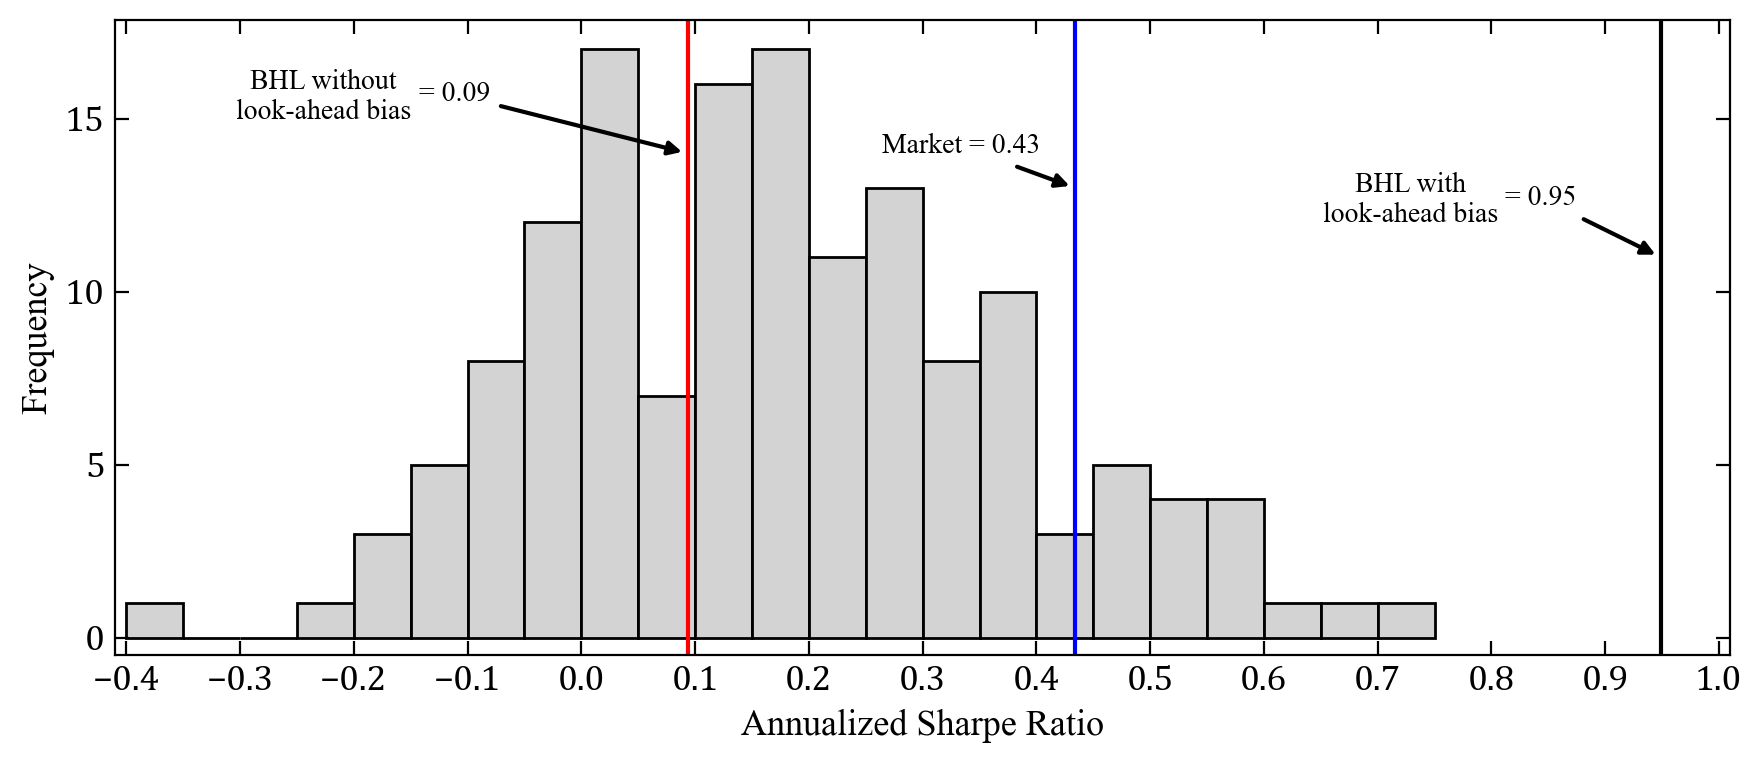

In [245]:
plt.rcParams['font.sans-serif']=['Times New Roman'] 
fig, ax = plt.subplots(1,1, figsize=(9,4))
sharpe_res['Sharpe'].hist(bins=np.arange(-0.4,0.76,0.05), ax=ax, color='lightgrey', edgecolor='black')
ax.tick_params(axis='x', which='both', direction='in', top=True, length=5, labelfontfamily='Cambria')  
ax.tick_params(axis='y', which='both', direction='in', right=True, length=5, labelfontfamily='Cambria')  
ax.set_xticks(np.arange(-0.4,1.1,0.1), )
ax.set_yticks(np.arange(0,20,5))
ax.grid(False, axis='both')
ax.set_xlabel('Annualized Sharpe Ratio')
ax.set_ylabel('Frequency')
ax.margins(x=0.01, y=0.05)
y_min, y_max = ax.get_ylim() 
ax.set_ylim(y_min - 0.5, y_max)
ax.set_xlim(-0.41, 1.01)  

# 假设箭头对应的 Sharpe Ratio 和 y 轴位置
arrows = [
    {"x": 0.43, "y": 15, "text": "Market = 0.43", "arrow_y": 14},
    {"x": 0.95, "y": 18, "text": "BHL with look-ahead bias = 0.95", "arrow_y": 17},
    {"x": 0.09, "y": 12, "text": "BHL without look-ahead bias = 0.09", "arrow_y": 11},
]

# Mkt
ax.axvline(Mkt, color='blue', linestyle='-')
ax.annotate(
        "Market = 0.43", xy=(Mkt, 13),  
        xytext=(Mkt - 0.1, 14),  
        arrowprops=dict(
            arrowstyle="-|>", color="black", lw=1.5  
        ),   fontsize=10, ha="center",
    )


# BHL
ax.axvline(BHL, color='black', linestyle='-')
ax.text(BHL-0.22, 12, "BHL with\nlook-ahead bias", fontsize=10, ha='center')
ax.annotate(
        "= 0.95",  xy=(BHL, 11),  
        xytext=(BHL - 0.105, 12.5),  
        arrowprops=dict(
            arrowstyle="-|>", color="black", lw=1.5  
        ),
        fontsize=10, ha="center",
    )

# RF without look-ahead bias
ax.axvline(RF, color='red', linestyle='-')
ax.text(RF-0.32, 15, "BHL without\nlook-ahead bias", fontsize=10, ha='center')
ax.annotate(
        "= 0.09",  xy=(RF, 14),  
        xytext=(RF - 0.205, 15.5),  
        arrowprops=dict(
            arrowstyle="-|>", color="black", lw=1.5  
        ),
        fontsize=10, ha="center",
    )
plt.tight_layout()
plt.savefig('../data/Results/ASR_3.pdf', dpi=300, bbox_inches='tight')

In [193]:
sharpe_res.sort_values(by='Sharpe').tail(5)

,Var,Sharpe
18,CBOperProf,0.581362
88,MomSeason,0.598806
7,AnnouncementReturn,0.643943
121,Tax,0.656097
89,MomSeason06YrPlus,0.736566


In [199]:
## [La Porta (1996) average return in footnote 1]
# La Port 1996 in post_2000 sample
crsp_2000 = crsp[crsp['YearMonth'] >= '2000-01-01']
df_ = crsp_2000[['permno','YearMonth','ME','bh1m']].merge(osap[['permno','YearMonth','fgr5yrLag']], on=['permno','YearMonth'], how='left')
_,vwret = utils.SingleSort(df_, 
                           'permno', 'YearMonth', 
                           'fgr5yrLag', 'bh1m', 5, 'ME', 
                           quantile_filter=None)
utils.SingleSort_RetAna(_, vwret, 'YearMonth', factor_data=None, factor_dict={'Ret':['ones']}, lag=12, float_format='%.3f')

Var:fgr5yrLag, Delete 123146 rows due to missing values, raw data 410891 rows --> new data 287745 rows


,1,2,3,4,5,H-L
Ret,0.659,0.551,0.726,0.650,0.830,0.172
,(1.27),(1.58),(2.40),(2.15),(3.87),(0.40)
